# Graph Convolutional Network

My attempt at building a simple 2-layer Graph Convolution Neural Network for graph classification with Pytorch.

Utilises the definitions and architecture outlined in _Kipf & Welling, [Semi-Supervised Classification with Graph Convolutional Networks](http://arxiv.org/abs/1609.02907) (ICLR 2017)_.

## Imports and dataset

In [1]:
!pip install dgl
# !pip install -U networkx

     |████████████████████████████████| 2.4MB 2.9MB/s 


In [0]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.sparse as sps
import torch
from torch import nn
import torch.nn.functional as F

%matplotlib inline

In [0]:
N_classes = 8

def one_hot(idx):
    """
    Method to one hot encode class number

    Params:
        idx: class number / index to assign to 1
    Returns:
        vec: tensor of length N_classes, containing all 0s except the position of idx
    """
    vec = torch.zeros(N_classes)
    vec[idx] = 1
    return vec

def un_one_hot(vec):
    """
    Method to get the class/index given a one hot encoded vector
    """
    return int(torch.where(vec == 1)[0])

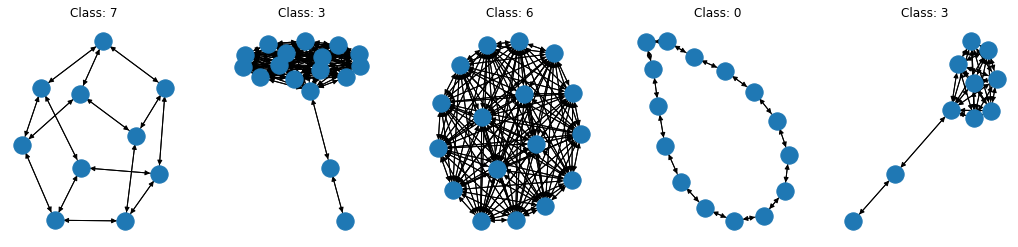

In [28]:
gcdataset = MiniGCDataset(50,10,20)

# convert DGLgraph to networkx
# each entry in dataset: (networkx graph, label)
dataset = []
for i in np.arange(50):
    graph, label = gcdataset[i]
    label = one_hot(label)
    graph = graph.to_networkx()
    node_attrs = {i: list(torch.randn(2)) for i in np.arange(graph.number_of_nodes())}
    nx.set_node_attributes(graph, node_attrs, 'name') # add random 2-length vector as node attribute for all nodes (attribute 'name')
    dataset.append( (graph, label) )
    
# show samples from dataset
plt.figure(figsize=(18,4))
for i, g in enumerate(np.random.randint(0, 50, 5)):
    graph, label = dataset[g]
    label = un_one_hot(label)
    plt.subplot(1,5,i+1)
    nx.draw(graph)
    plt.title('Class: {}'.format(label));

## Graph convolution

A graph convolution is defined as follows (eqn. 8 in _Kipf & Welling_). 

For a signal $X \in \mathbb{R}^{N \times C}$ with $N$ nodes and $C$ input channels, and $F$ filters or feature maps:
$$ Z = \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} X \Theta ,$$

where:
* $Z \in \mathbb{R}^{N \times F}$ is the convolved signal matrix
* $\Theta \in \mathbb{R}^{C \times F}$ is a matrix of filter parameters
* $\tilde{A} = A + I_N$ is the adjacency matrix A with added self-connections
* $\tilde{D} = \sum_j \tilde{A}_{ij}$ is the degree matrix of the new adjacency matrix

Here a _renormalisation trick_ is performed, such that the rescaled, normalised graph Laplacian with self-loops is expressed by $\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}$.

In [0]:
def get_feature_matrix(g):
    """
    Method to gather a graph's node features as matrix.

    Params:
        g: networkx graph
    Returns:
        X: A tensor of size N x C, where N = no. of nodes & C = no. of channels.
    """
    return torch.Tensor(list(nx.get_node_attributes(g, 'name').values()))

### Example graph convolution

In [31]:
g = dataset[0][0]
N = g.number_of_nodes()
X = get_feature_matrix(g)

ϴ = nn.Linear(in_features=2, out_features=3)
A = torch.Tensor( nx.adjacency_matrix(g).todense() ) # A = dense adj. matrix as Tensor

A_tilde = A + torch.eye(N) # add self-connections
D_tilde = torch.sum(A_tilde, 1) # degree matrix of A_tilde
D_tilde_half = (D_tilde + 1e-5) ** (-0.5)
L_tilde = D_tilde_half * A * D_tilde_half # rescaled normalised graph Laplacian

Z = ϴ(torch.mm(L_tilde, X))
Z

tensor([[ 0.2941, -0.1080, -0.8804],
        [ 0.1321, -0.3658, -1.0454],
        [ 0.2567, -0.5012, -0.4612],
        [ 0.2783, -0.4994, -0.3946],
        [ 0.4084, -0.3620, -0.1667],
        [ 0.4709, -0.2605, -0.1058],
        [ 0.4648, -0.2310, -0.1658],
        [ 0.4526, -0.1438, -0.3241],
        [ 0.3345, -0.2156, -0.6037],
        [ 0.4869, -0.1990, -0.1387],
        [ 0.4746, -0.2817, -0.0651],
        [ 0.4570, -0.2832, -0.1192],
        [ 0.3789, -0.2946, -0.3534],
        [ 0.4576, -0.3218, -0.0644],
        [ 0.4122, -0.1227, -0.4825],
        [ 0.3134, -0.0658, -0.8764],
        [ 0.2911,  0.0772, -1.1437],
        [ 0.2851, -0.0146, -1.0370]], grad_fn=<AddmmBackward>)

## GCN torch Layer

In [0]:
class GCNLayer(nn.Module):
    """
    Torch Module for a single graph convolution.
    """

    def __init__(self, C, F):
        """
        Params:
            C: No. of channels in input signal. i.e. length of node feature vector.
            F: No. of filters/ feature banks.
        """
        super(GCNLayer, self).__init__() #idk what this does?
        self.ϴ = nn.Linear(in_features=C, out_features=F)
        
    def forward(self, g, X):
        """
        Params:
            g: input graph (networkx)
            X: feature matrix / signal from prev layer. Use get_feature_matrix(g) for first network layer.
        """
        N = g.number_of_nodes()
        A = torch.Tensor( nx.adjacency_matrix(g).todense() ) # A = dense adj. matrix as Tensor

        A_tilde = A + torch.eye(N) # add self-connections
        D_tilde = torch.sum(A_tilde, 1) # degree matrix of A_tilde
        D_tilde_half = (D_tilde + 1e-5) ** (-0.5)
        L_tilde = D_tilde_half * A * D_tilde_half # rescaled normalised graph Laplacian

        Z = self.ϴ(torch.mm(L_tilde, X))
        return Z

### Example GCN layer

In [33]:
gcn = GCNLayer(C=2, F=5)
gcn(g, get_feature_matrix(g))

tensor([[ 0.3495, -0.2608, -0.0939, -0.3798, -0.5149],
        [ 0.7046,  0.4237, -0.7431, -0.5845, -0.1599],
        [ 0.9240,  0.2319, -0.6108, -0.8877,  0.0475],
        [ 0.9247,  0.1732, -0.5600, -0.9054,  0.0470],
        [ 0.7423, -0.3067, -0.1152, -0.8371, -0.1378],
        [ 0.6022, -0.5730,  0.1377, -0.7553, -0.2778],
        [ 0.5577, -0.5864,  0.1563, -0.7089, -0.3209],
        [ 0.4272, -0.6419,  0.2248, -0.5772, -0.4476],
        [ 0.5147, -0.2591, -0.1211, -0.5661, -0.3559],
        [ 0.5140, -0.6767,  0.2415, -0.6854, -0.3647],
        [ 0.6340, -0.5613,  0.1227, -0.7880, -0.2469],
        [ 0.6336, -0.5136,  0.0813, -0.7737, -0.2465],
        [ 0.6382, -0.2967, -0.1076, -0.7166, -0.2378],
        [ 0.6905, -0.4765,  0.0403, -0.8275, -0.1909],
        [ 0.3897, -0.5566,  0.1566, -0.5103, -0.4819],
        [ 0.2904, -0.3539, -0.0039, -0.3397, -0.5736],
        [ 0.0759, -0.4385,  0.1029, -0.1215, -0.7816],
        [ 0.2103, -0.3309, -0.0113, -0.2425, -0.6502]],
       gr

## Network for classsification

In [0]:
class Classifier(nn.Module):
    """
    2 layer Graph CNN for graph classification
    """

    def __init__(self, c, f_in, f_hidden, n_classes):
        """
        Params:
            c: No. of channels. (Length of node feature vector)
            f_in: No. of filters in input layer
            f_hidden: No. of filters in hidden layer
            n_classes: No. of output classes
        """
        super(Classifier, self).__init__()

        self.gcn1 = GCNLayer(C=c, F=f_in)
        self.gcn2 = GCNLayer(C=f_in, F=f_hidden)

        self.classify = nn.Linear(f_hidden, n_classes)


    def forward(self, g):
        """
        Params:
            g: input graph (networkx)
        Returns:
            Z: classifier output
        """
        Z = F.relu(self.gcn1(g, get_feature_matrix(g)))
        Z = F.relu(self.gcn2(g, Z))
        Z = self.classify(Z).mean(axis=0) # mean reduce, row-wise
        Z = F.softmax(Z, dim=0)
        return Z

In [37]:
model = Classifier(c=2, f_in=7, f_hidden=5, n_classes=8)
model

Classifier(
  (gcn1): GCNLayer(
    (Θ): Linear(in_features=2, out_features=7, bias=True)
  )
  (gcn2): GCNLayer(
    (Θ): Linear(in_features=7, out_features=5, bias=True)
  )
  (classify): Linear(in_features=5, out_features=8, bias=True)
)

In [44]:
predict = model(g)
predict

tensor([0.1341, 0.1622, 0.1058, 0.1161, 0.1087, 0.1472, 0.1046, 0.1213],
       grad_fn=<SoftmaxBackward>)